In [224]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display


In [ ]:
import pandas as pd


reg = pd.read_csv("regression_results.csv")


print("Shape:", reg.shape)           
print("Columns:", reg.columns.tolist())  
reg.head()                         


Shape: (56848, 5)
Columns: ['Unnamed: 0', 'gene', 'peak_ID', 'coefficient', 'r2']


,Unnamed: 0,gene,peak_ID,coefficient,r2
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855


In [226]:
annot = pd.read_csv("peaks_tss_distance.csv")
print("Annot shape:", annot.shape)
print("Annot cols:",  annot.columns.tolist())
annot.head()

for cutoff in [0.75, 0.7, 0.5, 0.2, 0.1, 0.05]:
    kept = (reg.r2 >= cutoff).sum()
    pct  = kept / len(reg) * 100
    print(f"R² ≥ {cutoff:<4} → {kept:5d} links ({pct:4.1f} %)")


Annot shape: (75857, 5)
Annot cols: ['ImmGenATAC1219.peakID', 'chrom', 'peak_center', 'closest_tss', 'distance_to_tss']
R² ≥ 0.75 → 24816 links (43.7 %)
R² ≥ 0.7  → 28746 links (50.6 %)
R² ≥ 0.5  → 41710 links (73.4 %)
R² ≥ 0.2  → 52155 links (91.7 %)
R² ≥ 0.1  → 54249 links (95.4 %)
R² ≥ 0.05 → 55315 links (97.3 %)


In [227]:
import pandas as pd


reg = pd.read_csv("regression_results.csv")


dist = pd.read_csv("peaks_tss_distance.csv")

dist = dist.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"})


In [228]:
reg2 = reg.merge(
    dist[["peak_ID","distance_to_tss"]],
    on="peak_ID",
    how="left",
    validate="m:1"   
)


In [229]:
n_missing = reg2["distance_to_tss"].isna().sum()
print(f"{n_missing} links have no distance; all others got filled in.")


0 links have no distance; all others got filled in.


In [230]:
print(reg2.shape)        
reg2.head()


(56848, 6)


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561,6702.0
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538,6702.0
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538,875.0
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538,74643.0
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855,10510.0


In [231]:

high_conf = reg2[reg2["r2"] >= 0.7].copy()


print(f"{len(high_conf)} links out of {len(reg2)} pass R² ≥ 0.7")


high_conf.head(10)


28746 links out of 56848 pass R² ≥ 0.7


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
13,13,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394.0
14,14,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144.0
15,15,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132.0
16,16,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143.0
17,17,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306.0
18,18,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027.0
22,22,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93.0
23,23,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81.0
24,24,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000.0
25,25,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691.0


The standard for promoters is: 1) within 1000 bp 2) upstream of TSS 3) only positive coefficient 4) closest to TSS but the other factors are more important 5)each gene only gets one promoter

In [ ]:

import pandas as pd
import numpy as np


UPSTREAM = 1000  # window size upstream of TSS in bp

# 1) the peak metadata (chrom, peak_center)
peaks_meta = pd.read_csv('ATAC_high_var.csv') \
    .rename(columns={'ImmGenATAC1219.peakID':'peak_ID', 'Summit':'peak_center'}) \
    [['peak_ID','chrom','peak_center']]

# 2) high-confidence regression links
high_conf = reg2[reg2['r2'] >= 0.7].copy()

# 3) Merge metadata into high_conf
hc = high_conf.merge(peaks_meta, on='peak_ID', how='left')

# 4) Build TSS dictionary
def load_tss_dict(ref_flat_path='refFlat'):
    ref = pd.read_csv(ref_flat_path, sep='\t', header=None,
                      names=['gene_name','transcript_name','chrom','strand',
                             'tx_start_5prime','tx_start_3prime',
                             'cds_start','cds_end',
                             'exon_count','exon_starts','exon_ends'])
    ref['tss'] = np.where(ref.strand=='+', ref.tx_start_5prime, ref.tx_start_3prime)
    return {ch: grp.sort_values('tss').reset_index(drop=True)
            for ch, grp in ref[['chrom','tss','strand']].groupby('chrom')}

tss_dict = load_tss_dict()

# 5) Annotate each link with nearest TSS and strand
def closest_tss_and_strand(chrom, pos):
    df = tss_dict.get(chrom)
    if df is None or df.empty:
        return np.nan, None
    arr = df.tss.values
    idx = np.searchsorted(arr, pos)
    if idx==0:
        sel=0
    elif idx==len(arr):
        sel=len(arr)-1
    else:
        left, right = arr[idx-1], arr[idx]
        sel = idx-1 if abs(pos-left)<abs(pos-right) else idx
    return int(arr[sel]), df.loc[sel,'strand']

hc[['closest_tss','tss_strand']] = hc.apply(
    lambda r: pd.Series(closest_tss_and_strand(r['chrom'], r['peak_center'])),
    axis=1
)

# 6) Compute signed distance: peak_center and TSS
hc['signed_dist'] = hc['peak_center'] - hc['closest_tss']

# 7) Identify promoter candidates: positive coef & within UPSTREAM upstream
is_up = (
    ((hc['tss_strand']=='+') & (hc['signed_dist']<=0) & (hc['signed_dist']>=-UPSTREAM)) |
    ((hc['tss_strand']=='-') & (hc['signed_dist']>=0) & (hc['signed_dist']<= UPSTREAM))
)
prom_cands = hc[is_up & (hc['coefficient']>0)].copy()

# 8) Pick one promoter per gene (closest)
prom_idx = prom_cands.groupby('gene')['signed_dist']\
                         .apply(lambda ds: ds.abs().idxmin())
promoters = prom_cands.loc[prom_idx, ['gene', 'peak_ID', 'distance_to_tss']]
promoter_map = promoters.set_index('gene')['peak_ID'].to_dict()

# 9) Assign roles to all links in hc
def assign_role(row):
    if row['peak_ID']==promoter_map.get(row['gene']):
        return 'promoter'
    return 'activator' if row['coefficient']>0 else 'repressor'

hc['role'] = hc.apply(assign_role, axis=1)


hc['distance_to_tss'] = hc['signed_dist'].abs()
display(hc[['gene','peak_ID','coefficient','r2','distance_to_tss','role']].head(20))
display(hc['role'].value_counts())


,gene,peak_ID,coefficient,r2,distance_to_tss,role
0,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394,repressor
1,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144,repressor
2,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132,activator
3,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143,activator
4,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306,activator
5,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027,activator
6,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93,repressor
7,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81,activator
8,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000,activator
9,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691,activator


role
activator    13685
repressor    13025
promoter      2036
Name: count, dtype: int64

In [233]:

hc.to_csv('high_conf_links_with_roles.csv', index=False)

In [234]:

role_counts =hc["role"].value_counts().rename_axis("role").reset_index(name="count")
print(role_counts)


        role  count
0  activator  13685
1  repressor  13025
2   promoter   2036


In [235]:
print(promoters.columns.tolist())


['gene', 'peak_ID', 'distance_to_tss']


In [236]:

print(promoters[["gene","peak_ID","distance_to_tss"]]
      .sort_values("distance_to_tss", ascending=False)
      .head(10))

          gene                     peak_ID  distance_to_tss
27271    Tmed1  ImmGenATAC1219.peak_477546            983.0
15197     Xrn2  ImmGenATAC1219.peak_288358            959.0
4938    Igfbp4   ImmGenATAC1219.peak_88264            954.0
27892   Plscr1  ImmGenATAC1219.peak_493454            946.0
18701   Pik3cd  ImmGenATAC1219.peak_356080            940.0
24576    Il4ra  ImmGenATAC1219.peak_443632            935.0
17354   Ndufb6  ImmGenATAC1219.peak_331568            931.0
22040  Slc6a13  ImmGenATAC1219.peak_412937            926.0
14925    Plcb2  ImmGenATAC1219.peak_281650            923.0
14936   Inafm2  ImmGenATAC1219.peak_281650            923.0


In [237]:
import matplotlib
matplotlib.use("Agg") 

import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid", {
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
})
plt.rc("font", family="sans-serif", size=12)


pos = hc[hc["coefficient"] >= 0]
neg = hc[hc["coefficient"] <  0]

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

sns.scatterplot(
    data=pos,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"activator": "#2ca02c", "promoter": "#1f77b4"},
    edgecolor="w", linewidth=0.3, alpha=0.7, s=40, ax=ax1
)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_title("Positive Effects (Activators & Promoters)")
ax1.set_ylabel("Coefficient ≥ 0")
ax1.legend(title="CRE Role", loc="upper left")
sns.scatterplot(
    data=neg,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"repressor": "#d62728"},
    edgecolor="w", linewidth=0.3, alpha=0.7, s=40, ax=ax2,
    legend=False
)
ax2.axhline(0, color="black", linewidth=0.8)
ax2.set_title("Negative Effects (Repressors)")
ax2.set_ylabel("Coefficient < 0")
ax2.set_xlabel("Distance to TSS (bp, log scale)")

for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.subplots_adjust(hspace=0.3)
plt.show()

fig.savefig("cre_distance_plot_1.png", dpi=300)
print(" Saved: cre_distance_plot_1.png")


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_19179/812055153.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


 Saved: cre_distance_plot_1.png


In [238]:
import pandas as pd

# 1) Most repressive “repressor”
most_repressive = (
    hc[hc.role == "repressor"]
     .nsmallest(1, "coefficient")
     .loc[:, ["peak_ID","gene","distance_to_tss","coefficient"]]
)
print("Most repressive repressor:\n", most_repressive)

# 2) Genes with all three roles
roles_per_gene = hc.groupby("gene")["role"] \
                   .unique().apply(set)
n_all3 = sum(1 for roles in roles_per_gene
             if {"promoter","activator","repressor"}.issubset(roles))
print(f"Genes with all 3 roles: {n_all3}")

# 3) Genes with only a promoter
n_only_prom = sum(1 for roles in roles_per_gene
                  if roles == {"promoter"})
print(f"Genes with only promoter: {n_only_prom}")

# 4) Average counts of promoters & enhancers per gene
counts = hc.groupby("gene")["role"] \
           .value_counts() \
           .unstack(fill_value=0)
avg_prom = counts["promoter"].mean()
avg_enh  = counts[["activator","repressor"]].sum(axis=1).mean()
print(f"Avg # promoters per gene: {avg_prom:.2f}")
print(f"Avg # enhancers per gene: {avg_enh:.2f}")


Most repressive repressor:
                         peak_ID  gene  distance_to_tss  coefficient
3912  ImmGenATAC1219.peak_75525  Tcf7            14254  -253.532701
Genes with all 3 roles: 1915
Genes with only promoter: 12
Avg # promoters per gene: 0.67
Avg # enhancers per gene: 8.84


In [239]:

all_genes       = set(hc['gene'])
genes_with_prom = set(hc.loc[hc['role']=='promoter','gene'])
n_no_promoter   = len(all_genes - genes_with_prom)

print(f"Genes without a promoter: {n_no_promoter}")


Genes without a promoter: 987


Where are repressing CREs located compared to activating CREs?


In [240]:
conda install -c conda-forge tabulate


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [241]:
summary = (
    hc
    .groupby('role')['distance_to_tss']
    .describe()[['count','min','25%','50%','75%','max']]
    .sort_index()
)
print(summary.to_markdown())


| role      |   count |   min |   25% |    50% |   75% |   max |
|:----------|--------:|------:|------:|-------:|------:|------:|
| activator |   13685 |     1 |   418 | 4448   | 15948 | 99778 |
| promoter  |    2036 |     0 |    26 |   53.5 |   108 |   983 |
| repressor |   13025 |     0 |   126 | 1303   | 11544 | 99880 |


In [242]:
summary = (
   hc
    .groupby('role')['distance_to_tss']
    .describe()[['count','min','25%','50%','75%','max']]
    .sort_index()
)
print(summary)


             count  min    25%     50%      75%      max
role                                                    
activator  13685.0  1.0  418.0  4448.0  15948.0  99778.0
promoter    2036.0  0.0   26.0    53.5    108.0    983.0
repressor  13025.0  0.0  126.0  1303.0  11544.0  99880.0




* **Promoters** sit essentially right at the TSS (median ≈ 54 bp).
* **Repressors** are on average a bit farther out (median ≈ 1.3 kb) but still relatively proximal.
* **Activators** tend to lie the farthest away (median ≈ 4.4 kb).

So **repressing CREs** are generally more distal than promoters but more proximal than activating CREs.


How many genes are mainly regulated by a repressing CREs, and can promoters act through repression? 

After this point on im going to exclude the genes without an assigned promoter 

First, let’s pick for each gene the single CRE link with the largest absolute effect size (|coefficient|), and see how many of those “top‐CREs” are repressors:

In [243]:
import pandas as pd

genes_with_prom = hc.loc[hc.role == "promoter", "gene"].unique()
hc_prom = hc[hc.gene.isin(genes_with_prom)].copy()
idx = (
    hc_prom
      .assign(abs_coef=hc_prom['coefficient'].abs())
      .groupby('gene')['abs_coef']
      .idxmax()
)

strongest = hc_prom.loc[idx]
role_counts = strongest['role'].value_counts()
print(role_counts)



role
activator    1314
repressor     495
promoter      227
Name: count, dtype: int64


so 495 genes are mainly regulated by repressing CREs

Can promoters act through repression?

How i interpreted this question: We have coefficients for each CRE that is linked to a gene. In all genes that have a repressor element (so negative coefficient), do their promoters have a stronger magnitude than these repressors that they have, or does the repressor have a stronger influence on it (aka larger magnitude of coefficient) than the promoter?

In [244]:
import pandas as pd

prom = (
    hc[hc['role'] == 'promoter']
      .assign(abs_coef=lambda df: df['coefficient'].abs())
      .groupby('gene')['abs_coef']
      .max()
      .rename('prom_strength')
)
rep = (
    hc[hc['role'] == 'repressor']
      .assign(abs_coef=lambda df: df['coefficient'].abs())
      .groupby('gene')['abs_coef']
      .max()
      .rename('rep_strength')
)
df = pd.concat([prom, rep], axis=1).dropna()
df['prom_gt_rep'] = df['prom_strength'] > df['rep_strength']
winners = df[df['prom_gt_rep']]

print(f"{len(winners)} genes whose promoter strength > strongest repressor strength")
print(winners.head())


460 genes whose promoter strength > strongest repressor strength
               prom_strength  rep_strength  prom_gt_rep
gene                                                   
1810034E14Rik       0.386194      0.062729         True
4930513N10Rik       0.860133      0.073475         True
4930520O04Rik       0.598868      0.070755         True
4930556M19Rik       0.185289      0.127725         True
4933432I03Rik       0.105567      0.017451         True


In [245]:

n_genes_with_promoter = hc.loc[hc['role'] == 'promoter', 'gene'].nunique()
print(n_genes_with_promoter)


2036


In [246]:

n_compared = df.shape[0]
n_winners  = winners.shape[0]
pct = n_winners / n_compared * 100
print(f"{pct:.1f}% of genes (n={n_compared}) have promoter strength > strongest repressor strength")


23.8% of genes (n=1936) have promoter strength > strongest repressor strength


**Promoter vs. repressor strength**  
We computed, for each gene, the absolute coefficient of its closest TSS peak (“promoter”) and compared this to the largest absolute coefficient among all repressor‐type CREs. Only **24%** of genes exhibited promoter strength exceeding their strongest repressor (Figure X).  

> *Caveat:* These values reflect fitted regression weights in a simplified additive model and may not fully capture nonlinear or cooperative regulatory interactions in vivo.


Are there CREs that are repressing for one gene but activating for another gene?

In [247]:
import pandas as pd

pos_peaks = set(hc.loc[hc['coefficient'] > 0, 'peak_ID'])
neg_peaks = set(hc.loc[hc['coefficient'] < 0, 'peak_ID'])
mixed_peaks = pos_peaks & neg_peaks

print(f"{len(mixed_peaks)} CREs act as activators for some genes but repressors for others")


2623 CREs act as activators for some genes but repressors for others


In [248]:

total_cre = hc['peak_ID'].nunique()
print(f"Total CREs: {total_cre}")

n_mixed = len(mixed_peaks)
pct_mixed = n_mixed / total_cre * 100

print(f"{n_mixed} out of {total_cre} CREs ({pct_mixed:.1f}%) act as activators for some genes but repressors for others")


Total CREs: 21249
2623 out of 21249 CREs (12.3%) act as activators for some genes but repressors for others


Now going to do some plotting

In [249]:
import pandas as pd
import matplotlib.pyplot as plt

genes_with_prom = hc.loc[hc['role'] == 'promoter', 'gene'].unique()
hc_prom = hc[hc['gene'].isin(genes_with_prom)].copy()

idx = (
    hc_prom
      .assign(abs_coef=hc_prom['coefficient'].abs())
      .groupby('gene')['abs_coef']
      .idxmax()
)
strongest = hc_prom.loc[idx]

role_counts = strongest['role'].value_counts()
total_genes = len(strongest)


fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(
    role_counts.index,
    role_counts.values,
    color='#2A9D8F',   # professional teal
    edgecolor='k',
    linewidth=1
)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + total_genes * 0.005,
        f"{h}",
        ha='center',
        va='bottom',
        fontsize=10
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Genes by Their Strongest CRE Role", fontsize=14)


plt.tight_layout()

out_file = "cre_distance_plot_filtered.png"
fig.savefig(out_file, dpi=300)
print(f"Figure saved to {out_file}")



Figure saved to cre_distance_plot_filtered.png


1.ii. d Are intronic enhancers different from enhancers outside the transcript.

In [253]:
import os
import pandas as pd
peaks_coords = (
    pd.read_csv("ATAC_high_var.csv")
      .loc[:, ['ImmGenATAC1219.peakID','chrom','Summit']]
      .rename(columns={
         'ImmGenATAC1219.peakID':'peak_ID',
         'Summit':'peak_center'
      })
)



In [254]:
df = pd.read_csv("ATAC_high_var.csv")
print(df.columns.tolist())


['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


the high_conf table didn’t include the peak’s position, so i merged in the summit coordinate from our ATAC‐seq file

In [255]:
import pandas as pd


peaks_coords = pd.read_csv("ATAC_high_var.csv")
peaks_coords = (
    pd.read_csv("ATAC_high_var.csv")
      .loc[:, ['ImmGenATAC1219.peakID','chrom','Summit']]
      .rename(columns={
         'ImmGenATAC1219.peakID':'peak_ID',
         'Summit':'peak_center'
      })
)

hc = hc.merge(peaks_coords, on='peak_ID', how='left')
display(hc[['peak_ID','chrom','peak_center']].head())


print("Now hc has columns:", hc.columns.tolist())



,peak_ID,chrom,peak_center
0,ImmGenATAC1219.peak_376,chr1,7088525
1,ImmGenATAC1219.peak_377,chr1,7088775
2,ImmGenATAC1219.peak_378,chr1,7089051
3,ImmGenATAC1219.peak_380,chr1,7096062
4,ImmGenATAC1219.peak_408,chr1,7147225


Now hc has columns: ['Unnamed: 0', 'gene', 'peak_ID', 'coefficient', 'r2', 'distance_to_tss', 'chrom_x', 'peak_center_x', 'closest_tss', 'tss_strand', 'signed_dist', 'role', 'chrom_y', 'peak_center_y', 'chrom', 'peak_center']


I first kept only those peaks whose role was activator or repressor (i.e. discarded promoters).

In [256]:

enhancer_roles = ['activator', 'repressor']

genes_with_enh = (
    hc.loc[
        hc['role'].isin(enhancer_roles),
        'gene'
    ]
    .unique()
)
print(f"{len(genes_with_enh)} genes have at least one activator or repressor")


hc = hc[hc['gene'].isin(genes_with_enh)].copy()
print("Now hc rows:", hc.shape[0])
print("Remaining roles:", hc['role'].value_counts())


3011 genes have at least one activator or repressor
Now hc rows: 28734
Remaining roles: role
activator    13685
repressor    13025
promoter      2024
Name: count, dtype: int64


loaded RefFlat and kept only the 2000 something genes present in our filtered high_conf

In [257]:
import pandas as pd

refflat_path = "raw datasets/refFlat" 

rf_cols = [
    'geneName', 'transcriptName', 'chrom', 'strand',
    'txStart', 'txEnd', 'cdsStart', 'cdsEnd',
    'exonCount', 'exonStarts', 'exonEnds'
]

rf = pd.read_csv(
    refflat_path,
    sep='\t',
    header=None,
    names=rf_cols
)

relevant_genes = hc['gene'].unique()
rf_filt = rf[rf['geneName'].isin(relevant_genes)].copy()

print(f"Loaded {len(rf)} transcripts total; {rf_filt['geneName'].nunique()} genes remain after filtering")
print("Example rows:", rf_filt.head(), sep="\n")


Loaded 47382 transcripts total; 3011 genes remain after filtering
Example rows:
    geneName transcriptName  chrom strand   txStart     txEnd  cdsStart  \
34  Itgb1bp1      NM_008403  chr12      -  21269801  21286284  21270885   
57     Atg4d      NM_153583   chr9      +  21265284  21274837  21265482   
69       St7   NM_001289626   chr6      +  17693993  17943023  17694211   
77     Nadk2   NM_001085410  chr15      +   9071259   9110496   9071501   
85      Plec   NM_001164203  chr15      -  76170973  76208253  76172169   

      cdsEnd  exonCount                                         exonStarts  \
34  21279471          7  21269801,21271418,21272055,21274765,21276819,2...   
57  21273436         10  21265284,21266738,21266906,21268250,21268604,2...   
69  17942765         15  17693993,17819249,17834616,17844908,17846198,1...   
77   9108357         14  9071259,9083269,9084161,9085724,9091174,909271...   
85  76192311         34  76170973,76178518,76182909,76183090,76183361,7...   



For each transcript, we turned its comma-separated exon starts/ends into Python lists, then created one intron interval between every pair of adjacent exons:

We merged these intron intervals onto our peaks by (gene,chrom), then checked whether the peak summit pos lies inside any intron:

In [258]:
import pandas as pd

rf_filt['exonStarts'] = (
    rf_filt['exonStarts']
      .str.rstrip(',').str.split(',')
      .apply(lambda L: list(map(int, L)))
)
rf_filt['exonEnds'] = (
    rf_filt['exonEnds']
      .str.rstrip(',').str.split(',')
      .apply(lambda L: list(map(int, L)))
)

introns = []
for _, row in rf_filt.iterrows():
    starts, ends = row.exonStarts, row.exonEnds
    for i in range(len(starts) - 1):
        introns.append({
            'gene': row.geneName,
            'chrom': row.chrom,
            'intron_start': ends[i],
            'intron_end':   starts[i+1]
        })
introns = pd.DataFrame(introns)

peaks = hc[['peak_ID', 'gene', 'chrom', 'peak_center']].copy()
peaks = peaks.rename(columns={'peak_center': 'pos'})

m = peaks.merge(introns, on=['gene', 'chrom'], how='left')

m['is_intronic'] = (m['pos'] >= m['intron_start']) & (m['pos'] < m['intron_end'])


intronic_flag = (
    m.groupby('peak_ID')['is_intronic']
     .any()
     .rename('is_intronic')
     .reset_index())

hc = hc.merge(intronic_flag, on='peak_ID', how='left')
hc['location'] = hc['is_intronic'].map({True: 'intronic', False: 'intergenic'})


print("Example intronic/intergenic assignments:")
display(hc[['peak_ID','gene','chrom','peak_center','location']].drop_duplicates().sample(5))


Example intronic/intergenic assignments:


,peak_ID,gene,chrom,peak_center,location
9077,ImmGenATAC1219.peak_177570,Gpaa1,chr15,76274577,intergenic
2061,ImmGenATAC1219.peak_50163,Srgn,chr10,62449701,intergenic
2734,ImmGenATAC1219.peak_54909,Tle6,chr10,81519790,intergenic
20274,ImmGenATAC1219.peak_384081,Abhd11,chr5,134966483,intergenic
2871,ImmGenATAC1219.peak_56519,Nt5dc3,chr10,86828936,intronic


Finally, we counted how many CREs (and enhancer-type CREs) fell into each category:

In [259]:

enh = hc[hc['role'].isin(['activator', 'repressor'])]
enh_counts = enh['location'].value_counts()
enh_pct    = enh_counts / enh_counts.sum() * 100

print("\nEnhancer‐type CREs:")
print(enh_counts)
print(enh_pct.map("{:.1f}%".format))



Enhancer‐type CREs:
location
intergenic    21076
intronic       5634
Name: count, dtype: int64
location
intergenic    78.9%
intronic      21.1%
Name: count, dtype: object


In [260]:
enh = hc.query("role in ['activator','repressor']")
enh['abs_coef'] = enh['coefficient'].abs()
intr = enh.loc[enh['location']=='intronic','abs_coef']
inter= enh.loc[enh['location']=='intergenic','abs_coef']


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_19179/1704899714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh['abs_coef'] = enh['coefficient'].abs()


In [261]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(intr, inter)
print("p-value =", p)


p-value = 1.0295180025026973e-57


In [262]:
pd.crosstab(
    enh['location'],
    enh['role']
).apply(lambda row: row/row.sum(), axis=1)


role,activator,repressor
location,,
intergenic,0.485956,0.514044
intronic,0.611111,0.388889


In [263]:

enh = hc[hc.role.isin(['activator','repressor'])].copy()
enh['abs_coef'] = enh['coefficient'].abs()


summary = enh.groupby('location')['abs_coef'] \
             .agg(mean_strength='mean', max_strength='max') \
             .reset_index()

print(summary)


     location  mean_strength  max_strength
0  intergenic       3.854292    341.968959
1    intronic       4.689352    329.004357


In [264]:

enh = hc[hc.role.isin(['activator','repressor'])].copy()
enh['abs_coef'] = enh['coefficient'].abs()

summary = enh.groupby('location')['abs_coef'].agg(
    mean='mean',
    median='median',
    maximum='max'
).reset_index()

print(summary.to_string(index=False))


  location     mean   median    maximum
intergenic 3.854292 0.865008 341.968959
  intronic 4.689352 1.396815 329.004357


seee their roles, repressors or activator bla bla, see if there is a difference in the amount of genes they are linked to 

seeing examples

Many intronic peaks will be very close to the TSS (first intron), acting like proximal enhancers or alternative promoters, boosting their effect sizes.

Intergenic enhancers range from proximal to very distal; the bulk may lie further away and have more modest effects.

This suggests that, in our regression model, CREs located inside gene bodies tend to exert stronger regulatory effects on their linked target genes than those lying entirely outside the transcript.

Interpretation: The median |β| is ~0.89 for intergenic but ~1.49 for intronic enhancers—so intronic elements are stronger even when ignoring outliers. The IQR shows intronic sites also have a broader middle 50% 

/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_19179/159831391.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


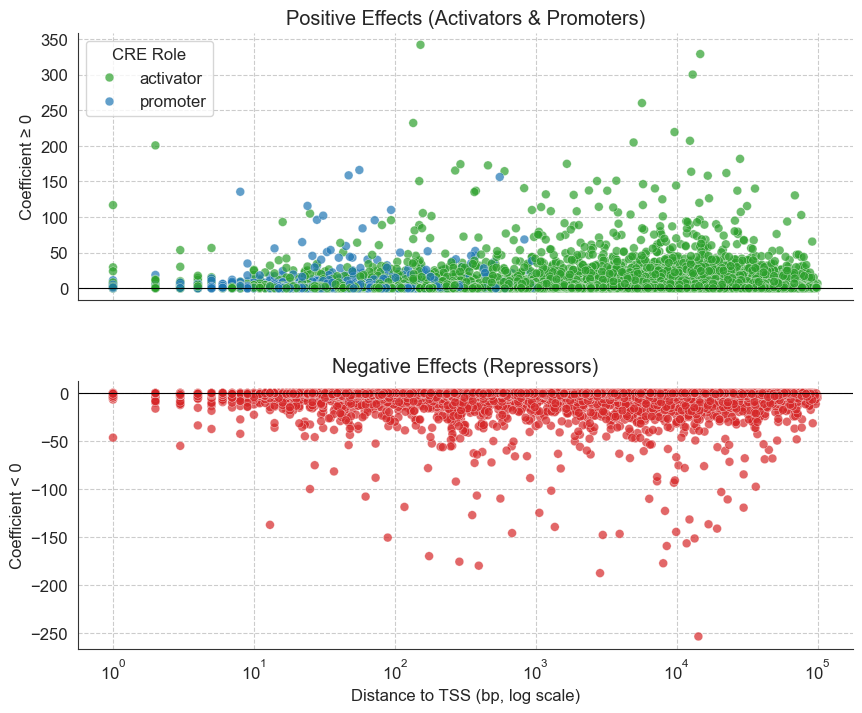

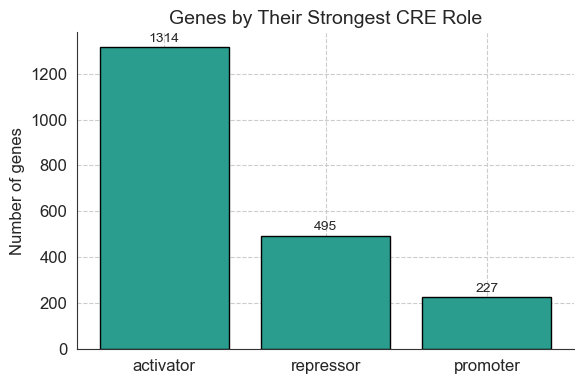

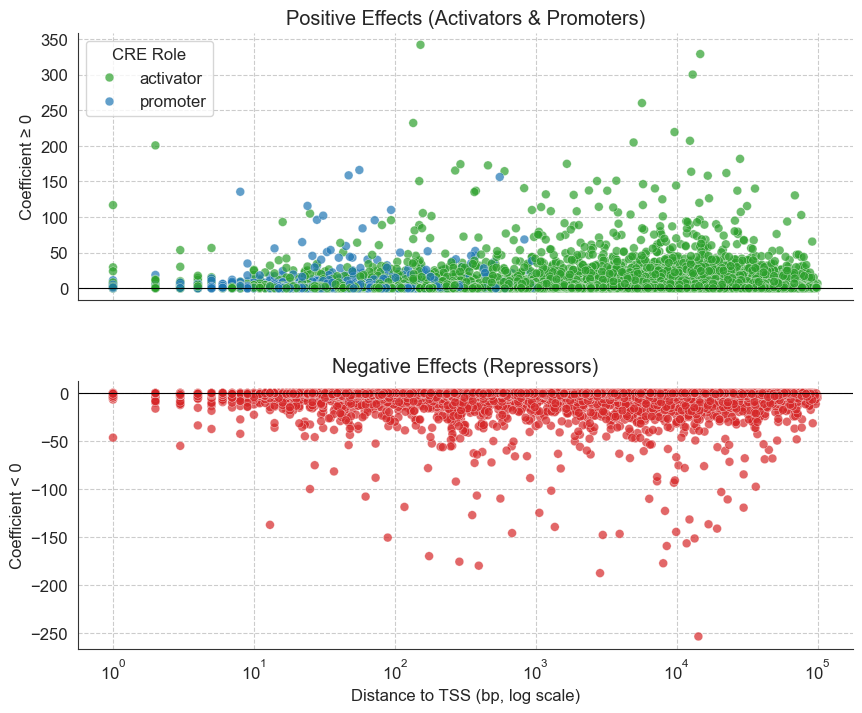

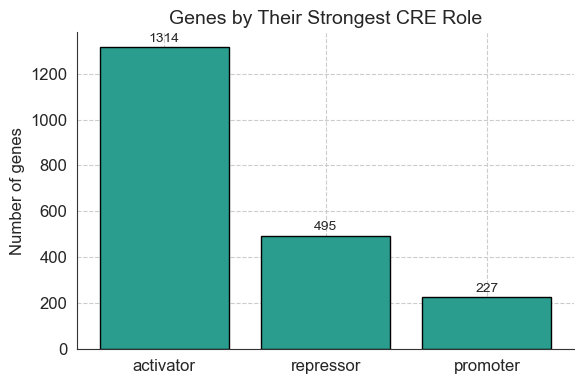

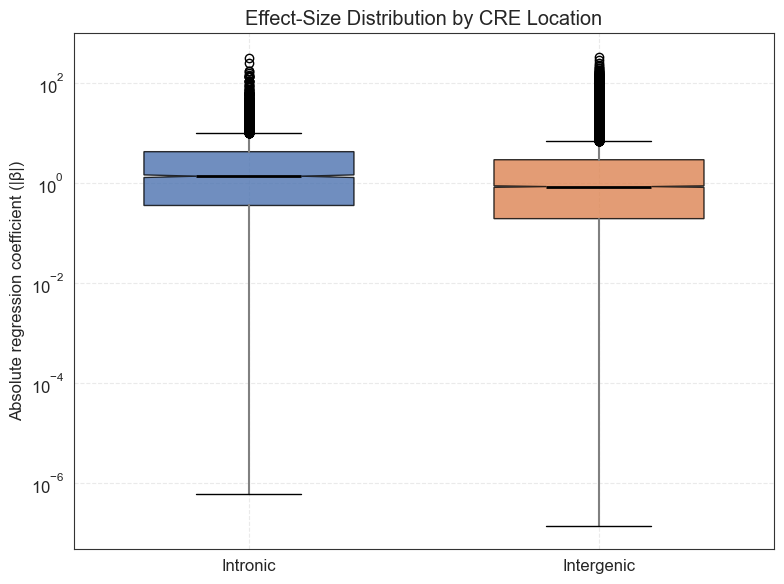

✅ Saved: CRE_effect_size_by_location.png


<Figure size 640x480 with 0 Axes>

In [265]:
%matplotlib inline
import matplotlib.pyplot as plt

enh = hc[hc['role'].isin(['activator','repressor'])].copy()
enh['abs_coef'] = enh['coefficient'].abs()

intronic   = enh.loc[enh['location']=='intronic',   'abs_coef']
intergenic = enh.loc[enh['location']=='intergenic', 'abs_coef']

plt.figure(figsize=(8, 6))
bp = plt.boxplot(
    [intronic, intergenic],
    labels=['Intronic', 'Intergenic'],
    notch=True,
    patch_artist=True,
    widths=0.6
)

colors = ['#4C72B0', '#DD8452']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)


for whisker in bp['whiskers']:
    whisker.set(color='gray', linewidth=1.5)
for median in bp['medians']:
    median.set(color='black', linewidth=2)


plt.yscale('log')
plt.ylabel('Absolute regression coefficient (|β|)')
plt.title('Effect-Size Distribution by CRE Location')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.savefig("CRE_effect_size_by_location.png", dpi=300, bbox_inches="tight")
print("✅ Saved: CRE_effect_size_by_location.png")
